In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Order/ConvolutionalAutoEncoder/
!ls

/content/drive/MyDrive/Order/ConvolutionalAutoEncoder
autoencoder_best_model_params.pt  best_model_params.pt	data  data.zip	pr.ipynb


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler, Subset, random_split
import cv2


cudnn.benchmark = True
plt.ion()


In [4]:
!ls

autoencoder_best_model_params.pt  best_model_params.pt	data  data.zip	pr.ipynb


In [5]:
# !unzip data.zip
# %ls

In [6]:
class ImageDataset(Dataset):
    def __init__(self, dataset_dir, train=False):
        self.data_transforms = {
                            'train': transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((256, 256)),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
                            'val': transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((256, 256)),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
                        }
        self.dataset_dir = dataset_dir

        self.labels = []
        self.raw_images = []
        self.train = train

        for dirpath, dirnames, filenames in os.walk(dataset_dir):
            for fn in filenames:
                label = 0 if 'normal' in dirpath else 1
                raw_img = cv2.imread(f'{dirpath}/{fn}')
                self.labels.append(label)
                self.raw_images.append(raw_img)

        self.train_images = [self.data_transforms['train'](img) for img in self.raw_images]
        self.test_images = [self.data_transforms['val'](img) for img in self.raw_images]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if self.train:
            return self.train_images[idx], self.labels[idx]
        else:
            return self.test_images[idx], self.labels[idx]

In [7]:
data_dir = 'data/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
n_images = 0
for dirpath, dirnames, filenames in os.walk(data_dir):
    n_images += len(filenames)

In [9]:
n_images

109

In [10]:
image_idxs = np.arange(n_images)

In [11]:
dataset = ImageDataset(data_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

trian/test split

In [12]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [13]:
class_names = {0: 'normal', 1: 'phishing'}

In [14]:
device

device(type='cuda', index=0)

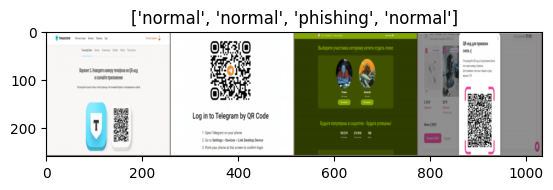

In [15]:
def imshow(inp, title=None):

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloader))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x.item()] for x in classes])

In [16]:
import torch.nn.functional as F

Build AutoEncoder model

In [17]:
class Encoder(nn.Module):
    def __init__(self, image_size, channels, embedding_dim):
        super(Encoder, self).__init__()

        self.channels = channels
        self.image_size = image_size
        self.embedding_dim = embedding_dim

        self.conv1 = nn.Conv2d(channels, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        self.shape_before_flattening = self.calculate_shape()
        flattened_size = (image_size // 8) * (image_size // 8) * 128
        self.fc = nn.Linear(flattened_size, embedding_dim)

    @torch.no_grad()
    def calculate_shape(self):
        x = torch.zeros((1, self.channels, self.image_size, self.image_size))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x.shape[1:]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [18]:
class Decoder(nn.Module):
    def __init__(self, embedding_dim, shape_before_flattening, channels):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(embedding_dim, np.prod(shape_before_flattening))
        self.reshape_dim = shape_before_flattening

        self.deconv1 = nn.ConvTranspose2d(
            128, 128, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.deconv2 = nn.ConvTranspose2d(
            128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.deconv3 = nn.ConvTranspose2d(
            64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
        )

        self.conv1 = nn.Conv2d(32, channels, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), *self.reshape_dim)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.sigmoid(self.conv1(x))
        return x

In [19]:
class ConvAutoencoder(nn.Module):
    def __init__(self, image_size, channels, embedding_dim, n_classes=1):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder(image_size, channels, embedding_dim)
        self.decoder = Decoder(embedding_dim, self.encoder.shape_before_flattening, channels)
        self.classifier = nn.Linear(embedding_dim, n_classes)

    def forward(self, x):
        embeddings = self.encoder(x)
        # logits = self.classifier(embeddings) # raw logits for classification head
        faked = self.decoder(embeddings)
        return faked

In [42]:
def train_autoencoder(num_epochs=25):
    since = time.time()
    sigm = nn.Sigmoid()

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs= []

    best_model_params_path = os.path.join('.', 'autoencoder_best_model_params.pt')

    best_loss = 1000

    img_shape = dataset[0][0].shape
    model = ConvAutoencoder(img_shape[1], img_shape[0], 1, 1)
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):
            print(f'Epoch: {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    loader = train_loader
                    model.train()
                else:
                    loader = test_loader
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in loader:
                    inputs = inputs.to(device)
                    labels = torch.unsqueeze(labels, 1).type('torch.FloatTensor').to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        # preds = torch.round(outputs)
                        loss = criterion(outputs, inputs)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    # running_corrects += torch.sum(preds == labels.data).item()

                if phase == 'train':
                    # scheduler.step()
                    fold_train_loss = running_loss / train_size
                    # fold_train_acc = running_corrects / train_size
                    train_losses.append(fold_train_loss)
                    # train_accs.append(fold_train_acc)
                    print(f'\t\ttrain loss: {fold_train_loss}')
                    # print(f'\t\ttrain acc: {fold_train_acc}')
                else:
                    fold_val_loss = running_loss / test_size
                    # fold_val_acc = running_corrects / test_size
                    val_losses.append(fold_val_loss)
                    # val_accs.append(fold_val_acc)
                    print(f'\t\tval loss: {fold_val_loss}')
                    # print(f'\t\tval acc: {fold_val_acc}')
                print()

            # mean validation loss
            if val_losses[epoch] < best_loss:
                best_loss = val_losses[epoch]
                torch.save(model.state_dict(), best_model_params_path)

    torch.save(model.state_dict(), best_model_params_path)

    time_elapsed = time.time() - since
    print()
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best mean val loss: {best_loss:4f}')

    model.load_state_dict(torch.load(best_model_params_path))

    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)
    # train_accs = np.array(train_accs)
    # val_accs = np.array(val_accs)


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')# Split the dataset into train and validation sets
    plt.legend()

    # plt.subplot(1, 2, 2)
    # plt.plot(train_accs, label='Training Accuracy')
    # plt.plot(val_accs, label='Validation Accuracy')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.legend()

    plt.show()

    return model

Epoch: 0/49
----------
		train loss: 2.644965700719548

		val loss: 2.0346482775428076

Epoch: 1/49
----------
		train loss: 2.4261712260629937

		val loss: 2.021162520755421

Epoch: 2/49
----------
		train loss: 2.398636774085034

		val loss: 2.012350927699696

Epoch: 3/49
----------
		train loss: 2.3799011734710342

		val loss: 1.9968228448521008

Epoch: 4/49
----------
		train loss: 2.343428968013018

		val loss: 1.9576034437526355

Epoch: 5/49
----------
		train loss: 2.314172555660379

		val loss: 1.8873755715110085

Epoch: 6/49
----------
		train loss: 2.1293558882570816

		val loss: 1.7682203162800183

Epoch: 7/49
----------
		train loss: 2.0111245108746933

		val loss: 1.7589900927110151

Epoch: 8/49
----------
		train loss: 2.0188429561154595

		val loss: 1.87408015944741

Epoch: 9/49
----------
		train loss: 2.00731617554851

		val loss: 1.8651235970583828

Epoch: 10/49
----------
		train loss: 2.017029085378537

		val loss: 2.198347893628207

Epoch: 11/49
----------
		train 

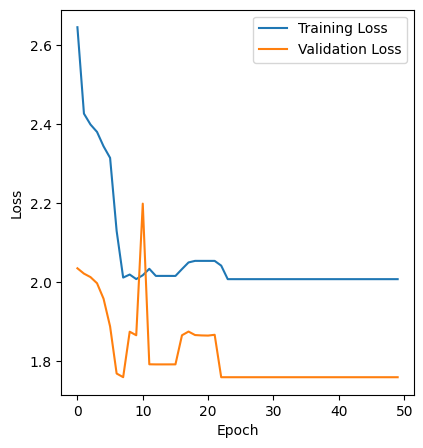

In [43]:
autoencoder = train_autoencoder(50)

In [45]:
img_shape = dataset[0][0].shape
model = ConvAutoencoder(img_shape[1], img_shape[0], 1, 1)
model.load_state_dict(torch.load('autoencoder_best_model_params.pt'))
model = model.to(device)

In [24]:
def train(num_epochs=25):
    since = time.time()
    sigm = nn.Sigmoid()

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs= []

    best_model_params_path = os.path.join('.', 'best_model_params.pt')

    best_acc = 0.0

    model = models.resnet18(weights='IMAGENET1K_V1')
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 1)
    # model.out = nn.Sigmoid(model.fc)

    model = model.to(device)

    criterion = nn.BCELoss()

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):
            print(f'Epoch: {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    loader = train_loader
                    model.train()
                else:
                    loader = test_loader
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in loader:
                    inputs = inputs.to(device)
                    labels = torch.unsqueeze(labels, 1).type('torch.FloatTensor').to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = sigm(model(inputs))
                        preds = torch.round(outputs)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data).item()

                if phase == 'train':
                    # scheduler.step()
                    fold_train_loss = running_loss / train_size
                    fold_train_acc = running_corrects / train_size
                    train_losses.append(fold_train_loss)
                    train_accs.append(fold_train_acc)
                    print(f'\t\ttrain loss: {fold_train_loss}')
                    print(f'\t\ttrain acc: {fold_train_acc}')
                else:
                    fold_val_loss = running_loss / test_size
                    fold_val_acc = running_corrects / test_size
                    val_losses.append(fold_val_loss)
                    val_accs.append(fold_val_acc)
                    print(f'\t\tval loss: {fold_val_loss}')
                    print(f'\t\tval acc: {fold_val_acc}')
                print()

            # mean validation loss
            if val_accs[epoch] > best_acc:
                best_acc = val_accs[epoch]
                torch.save(model.state_dict(), best_model_params_path)

    torch.save(model.state_dict(), best_model_params_path)

    time_elapsed = time.time() - since
    print()
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best mean val Acc: {best_acc:4f}')

    model.load_state_dict(torch.load(best_model_params_path))

    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)
    train_accs = np.array(train_accs)
    val_accs = np.array(val_accs)


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')# Split the dataset into train and validation sets
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    return model

In [25]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(DataLoader(dataset, batch_size=20,)):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [26]:
model_ft = models.resnet152(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 156MB/s]


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


Epoch: 0/9
----------
		train loss: 0.7138705517368755
		train acc: 0.7471264367816092

		val loss: 26.80980838428844
		val acc: 0.5454545454545454

Epoch: 1/9
----------
		train loss: 0.22701726785336418
		train acc: 0.8620689655172413

		val loss: 0.8596094903028146
		val acc: 0.8181818181818182

Epoch: 2/9
----------
		train loss: 0.2680201530456543
		train acc: 0.9310344827586207

		val loss: 0.26520273902199487
		val acc: 0.8636363636363636

Epoch: 3/9
----------
		train loss: 0.11219113641257944
		train acc: 0.9540229885057471

		val loss: 0.2770824581384659
		val acc: 0.9545454545454546

Epoch: 4/9
----------
		train loss: 0.6262815827824946
		train acc: 0.8160919540229885

		val loss: 18.378243235892363
		val acc: 0.5909090909090909

Epoch: 5/9
----------
		train loss: 0.3071829692899496
		train acc: 0.8735632183908046

		val loss: 0.3907952742143111
		val acc: 0.7727272727272727

Epoch: 6/9
----------
		train loss: 0.2467571947423891
		train acc: 0.9310344827586207

		val loss

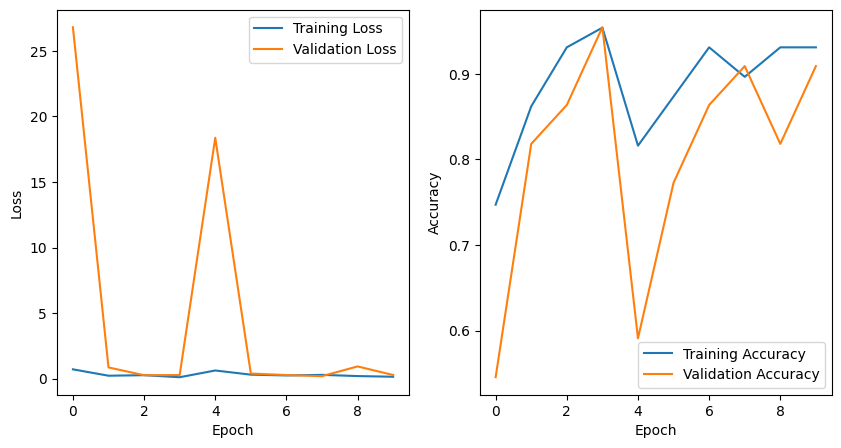

In [27]:
model_ft = train(num_epochs=10)

In [28]:
data = DataLoader(dataset, batch_size=8)
data.generator

In [29]:
dataset[1][0].unsqueeze(axis=0)

tensor([[[[ 0.1426,  0.1426,  0.1426,  ...,  0.1426,  0.0748, -0.9560],
          [ 0.1426,  0.1426,  0.1426,  ...,  0.1426,  0.0748, -0.9560],
          [ 0.1426,  0.1426,  0.1426,  ...,  0.1426,  0.0748, -0.9560],
          ...,
          [-1.3130, -1.3130, -1.3130,  ..., -1.3130, -1.3130, -1.3130],
          [-1.3130, -1.3130, -1.3130,  ..., -1.3130, -1.3130, -1.3130],
          [-1.3130, -1.3130, -1.3130,  ..., -1.3130, -1.3130, -1.3130]],

         [[ 0.9055,  0.9055,  0.9055,  ...,  0.9055,  0.8051, -0.7224],
          [ 0.9055,  0.9055,  0.9055,  ...,  0.9055,  0.8051, -0.7224],
          [ 0.9055,  0.9055,  0.9055,  ...,  0.9055,  0.8051, -0.7224],
          ...,
          [-0.9853, -0.9853, -0.9853,  ..., -0.9853, -0.9985, -1.1998],
          [-0.9853, -0.9853, -0.9853,  ..., -0.9853, -0.9985, -1.1998],
          [-0.9853, -0.9853, -0.9853,  ..., -0.9853, -0.9985, -1.1998]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.7797, -1.4024],
          [-1.8044, -1.8044, -

In [30]:
sigm = nn.Sigmoid()
model_ft.eval()
index = 40
input = dataset[index][0].unsqueeze(axis=0).to(device)
print(sigm(model_ft(input)))
print(dataset[index][1])

tensor([[0.1240]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0


In [31]:
# was_training = model.training
model_ft.eval()
# images_so_far = 0
# fig = plt.figure()
sigm = nn.Sigmoid()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(DataLoader(dataset, batch_size=100,)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = sigm(model_ft(inputs))

        # _, preds = torch.max(outputs, 1)

        break

        #     for j in range(inputs.size()[0]):
        #         images_so_far += 1
        #         ax = plt.subplot(num_images//2, 2, images_so_far)
        #         ax.axis('off')
        #         ax.set_title(f'predicted: {class_names[preds[j]]}')
        #         imshow(inputs.cpu().data[j])

        #         if images_so_far == num_images:
        #             model.train(mode=was_training)
        #             return
        # model.train(mode=was_training)
print([(i, j) for i, j in zip(labels, outputs)])
# print(outputs)

[(tensor(1, device='cuda:0'), tensor([0.9412], device='cuda:0')), (tensor(1, device='cuda:0'), tensor([0.9049], device='cuda:0')), (tensor(1, device='cuda:0'), tensor([0.9705], device='cuda:0')), (tensor(1, device='cuda:0'), tensor([0.9429], device='cuda:0')), (tensor(1, device='cuda:0'), tensor([0.9718], device='cuda:0')), (tensor(1, device='cuda:0'), tensor([0.9462], device='cuda:0')), (tensor(1, device='cuda:0'), tensor([0.9462], device='cuda:0')), (tensor(1, device='cuda:0'), tensor([0.9619], device='cuda:0')), (tensor(1, device='cuda:0'), tensor([0.8173], device='cuda:0')), (tensor(1, device='cuda:0'), tensor([0.9706], device='cuda:0')), (tensor(1, device='cuda:0'), tensor([0.8085], device='cuda:0')), (tensor(1, device='cuda:0'), tensor([0.9043], device='cuda:0')), (tensor(1, device='cuda:0'), tensor([0.9422], device='cuda:0')), (tensor(1, device='cuda:0'), tensor([0.9136], device='cuda:0')), (tensor(1, device='cuda:0'), tensor([0.9487], device='cuda:0')), (tensor(1, device='cuda:

In [32]:
labels[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')

In [33]:
outputs[:20].cpu().numpy().squeeze()

array([0.9412479 , 0.90493697, 0.97053146, 0.9428711 , 0.9717693 ,
       0.9462398 , 0.9462301 , 0.9619403 , 0.81728673, 0.9705824 ,
       0.80853534, 0.90431   , 0.942213  , 0.9135923 , 0.9487053 ,
       0.81278485, 0.886168  , 0.9373279 , 0.97328305, 0.9435963 ],
      dtype=float32)

In [34]:
outputs[0][0].item()

0.9412478804588318

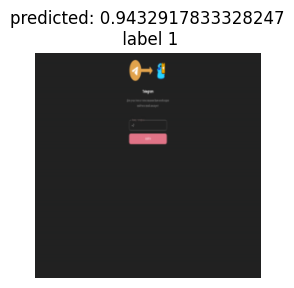

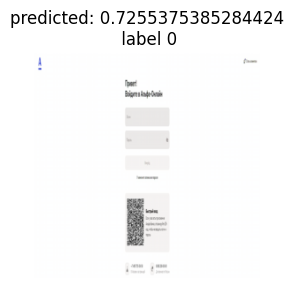

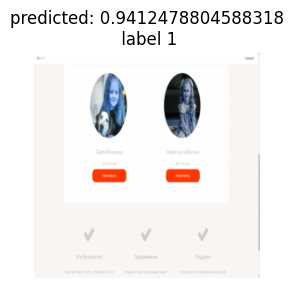

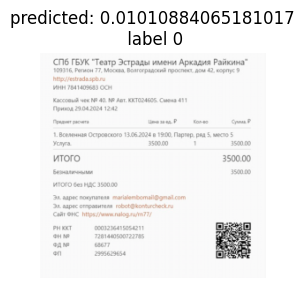

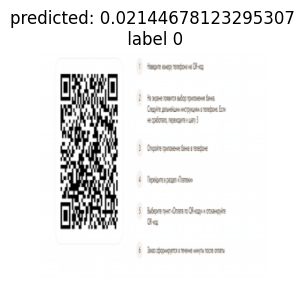

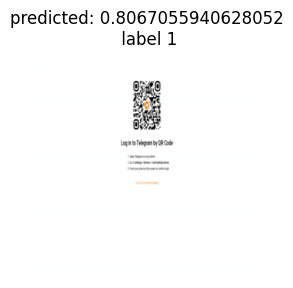

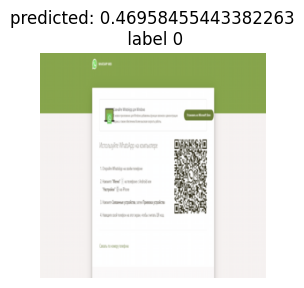

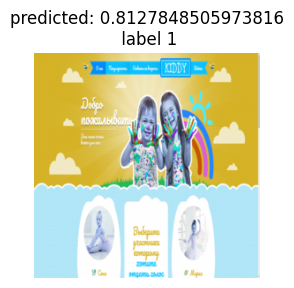

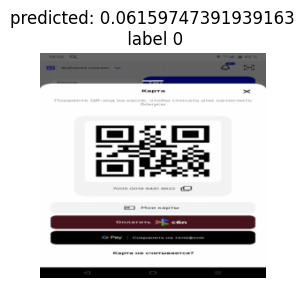

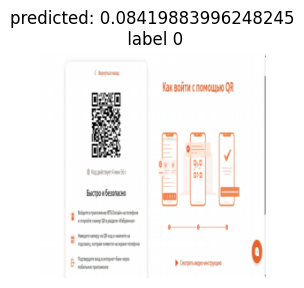

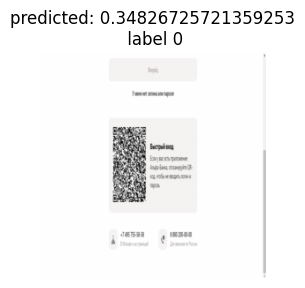

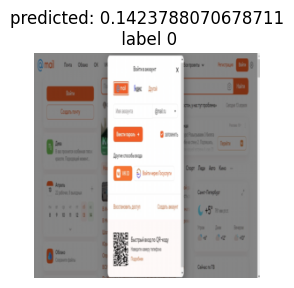

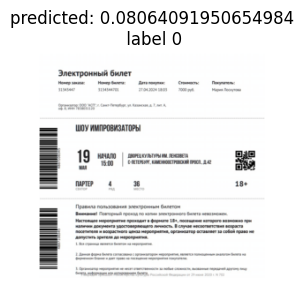

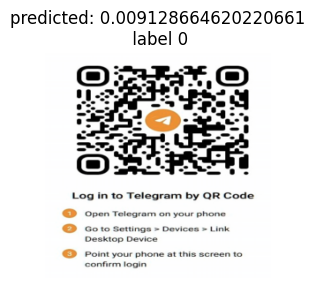

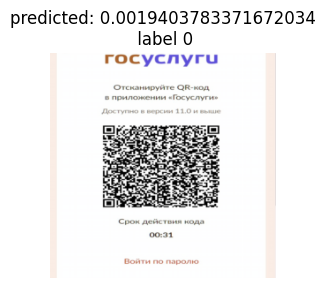

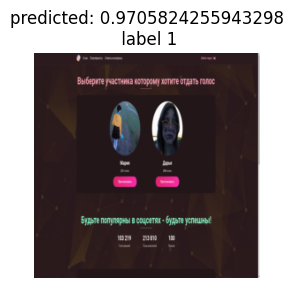

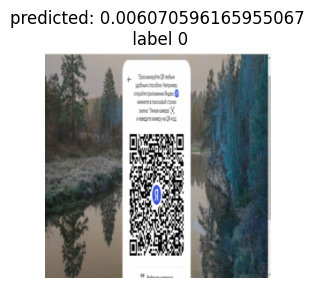

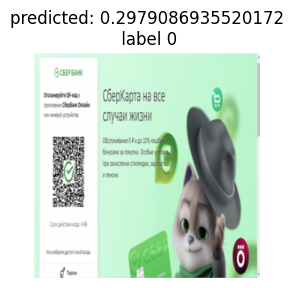

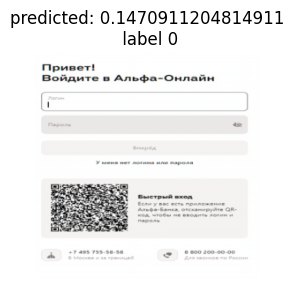

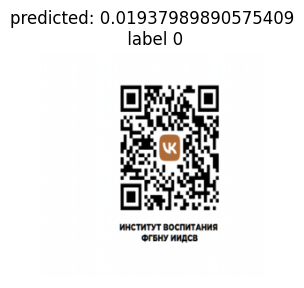

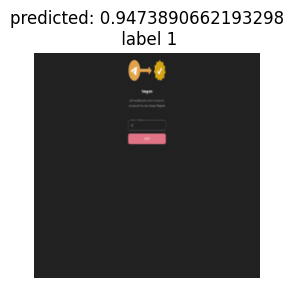

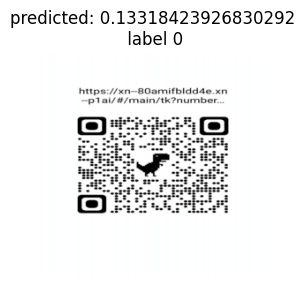

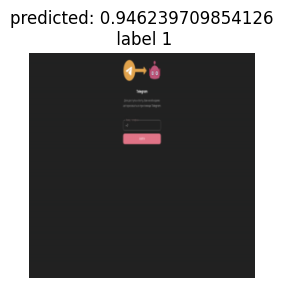

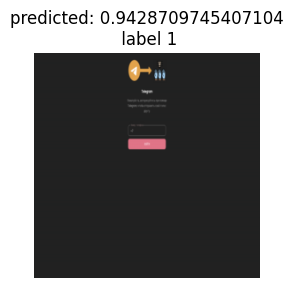

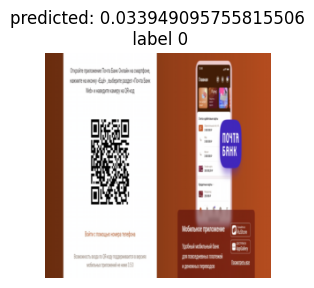

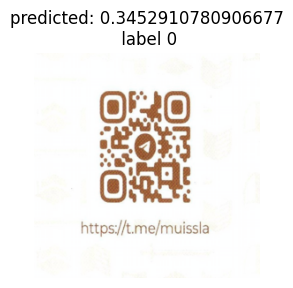

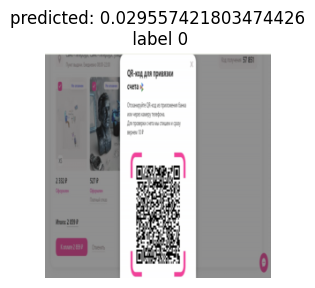

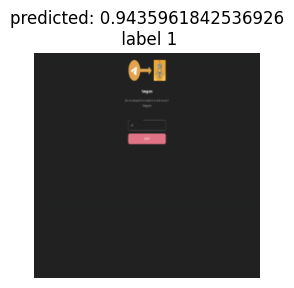

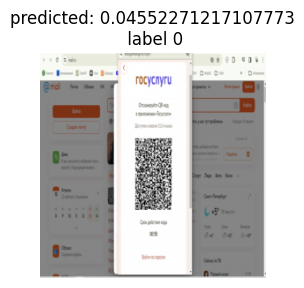

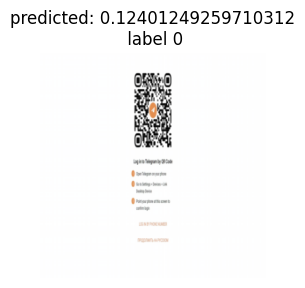

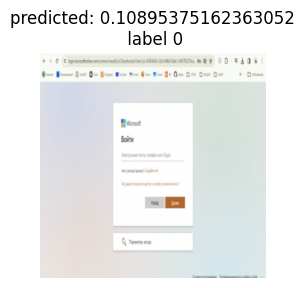

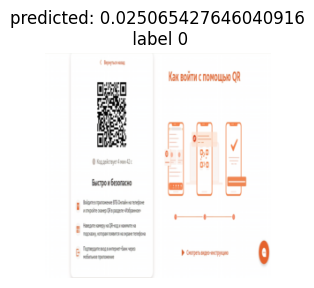

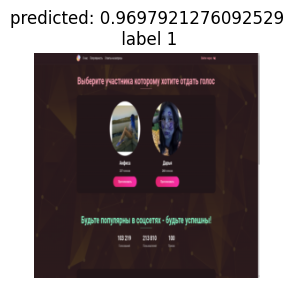

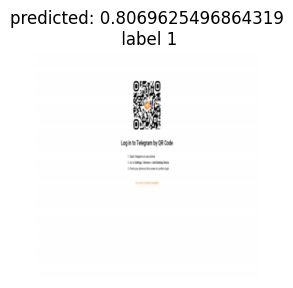

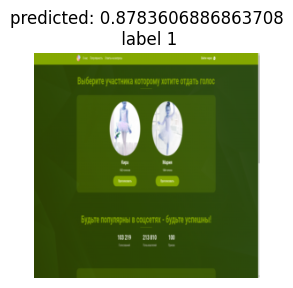

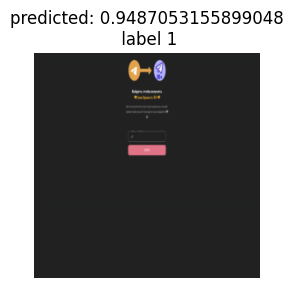

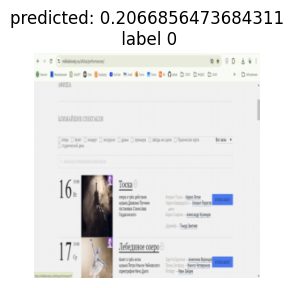

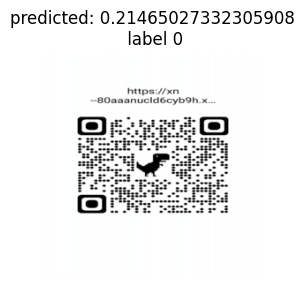

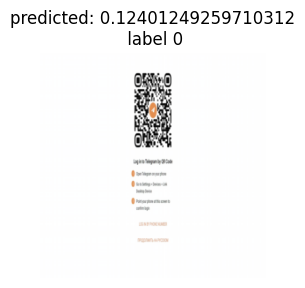

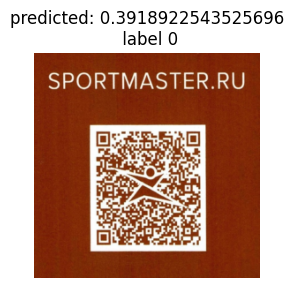

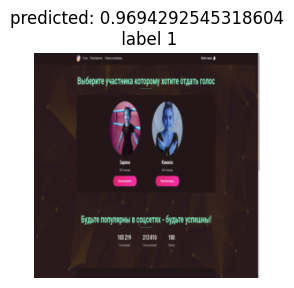

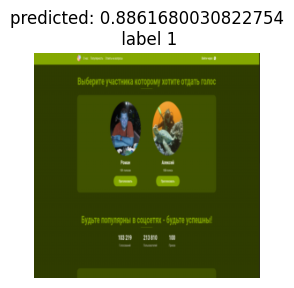

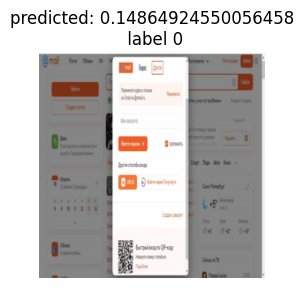

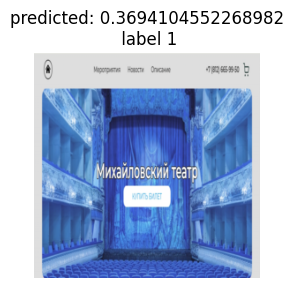

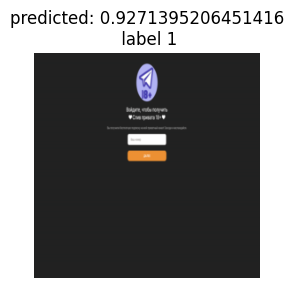

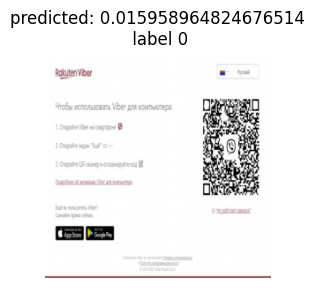

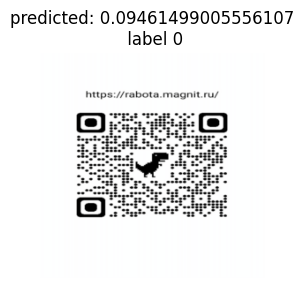

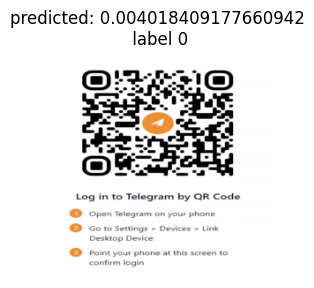

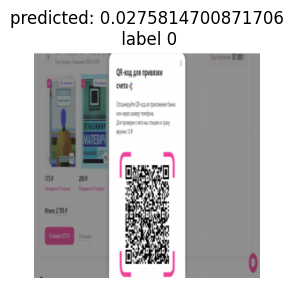

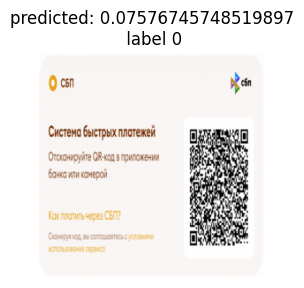

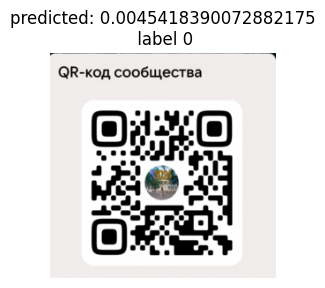

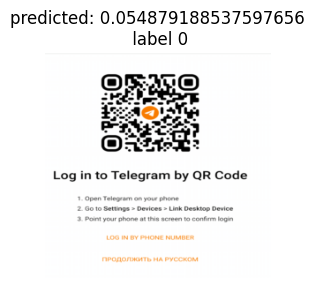

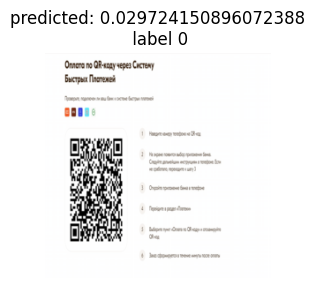

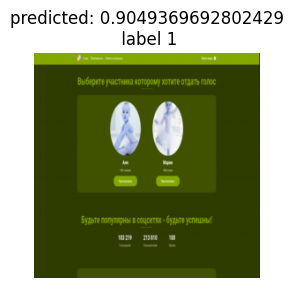

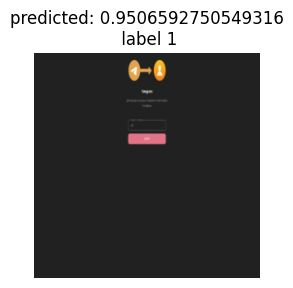

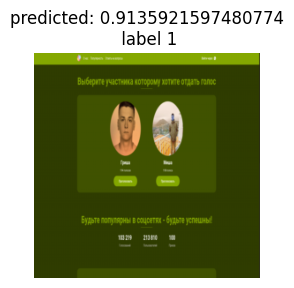

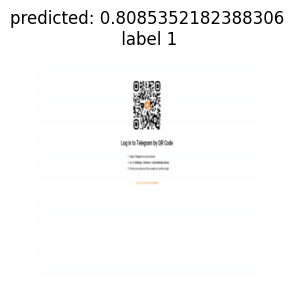

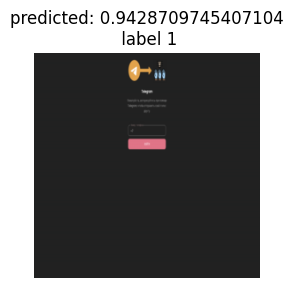

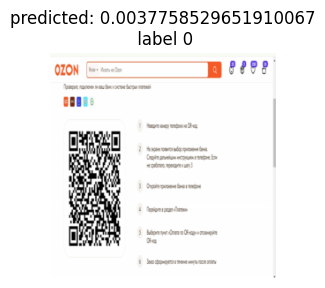

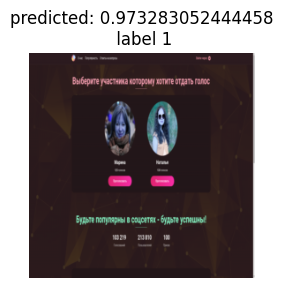

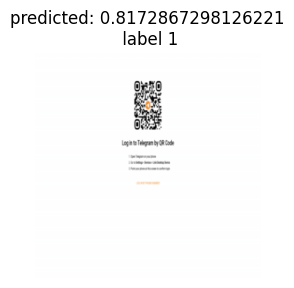

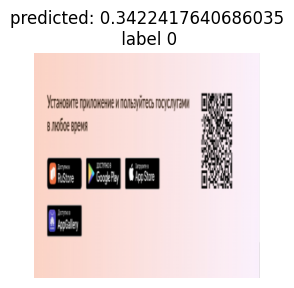

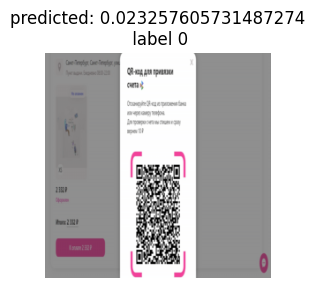

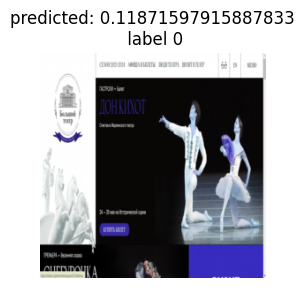

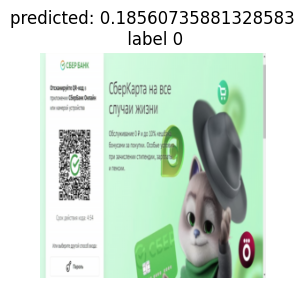

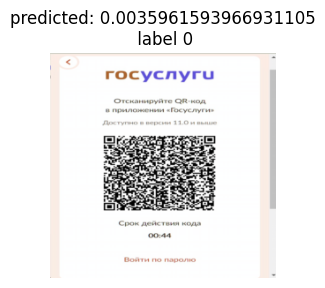

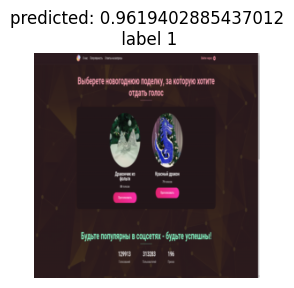

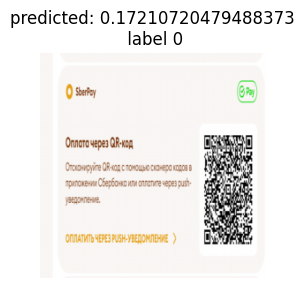

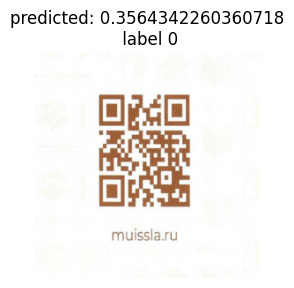

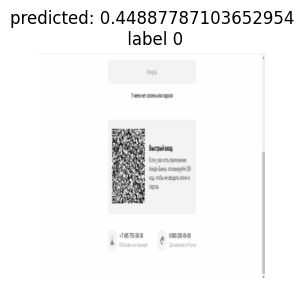

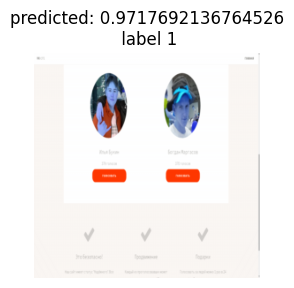

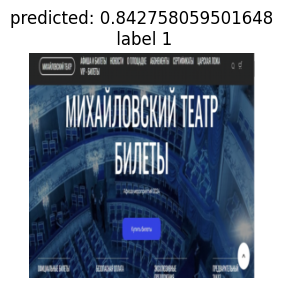

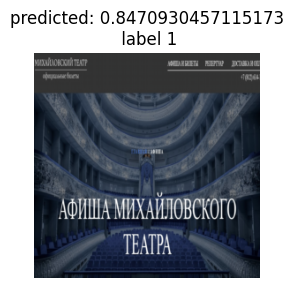

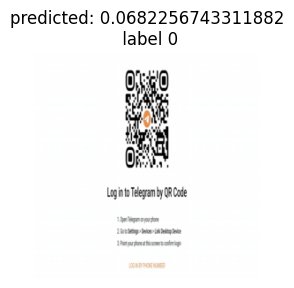

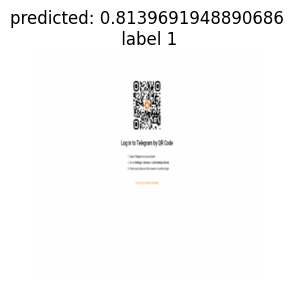

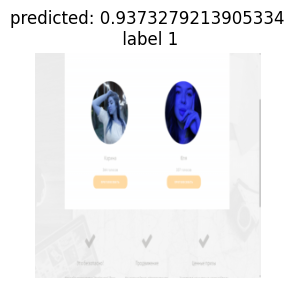

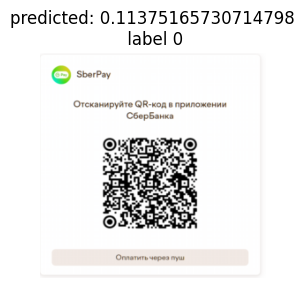

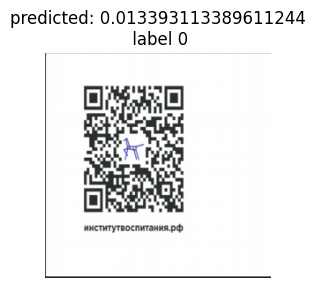

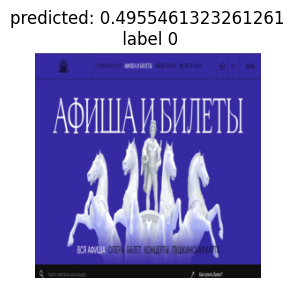

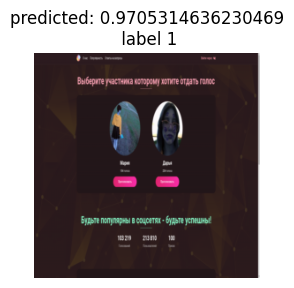

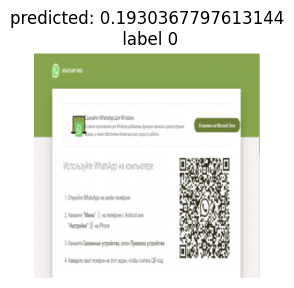

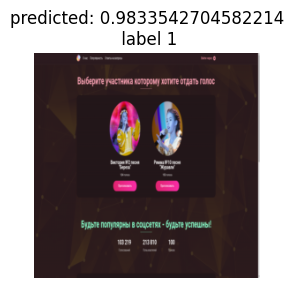

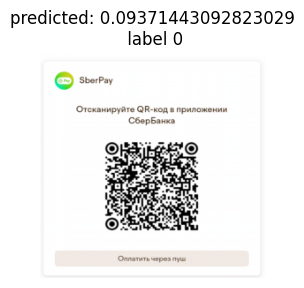

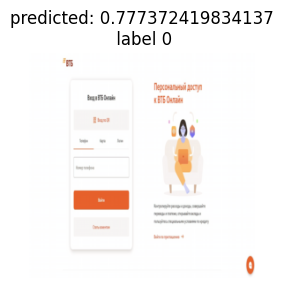

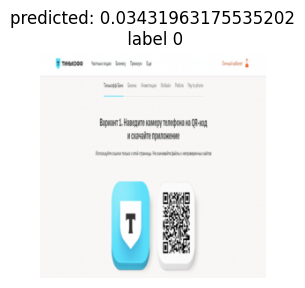

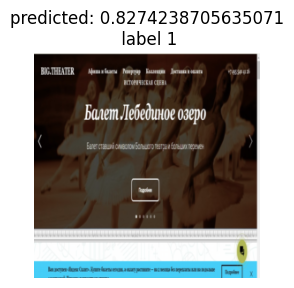

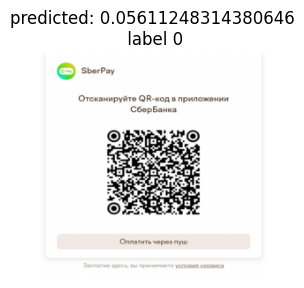

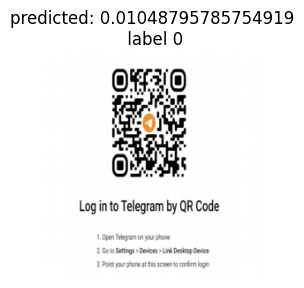

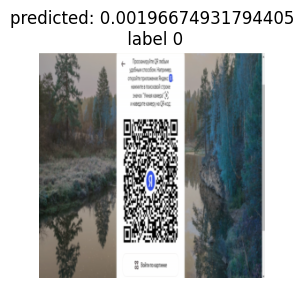

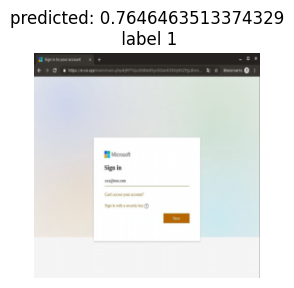

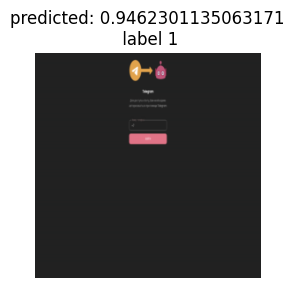

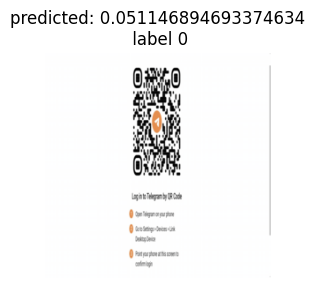

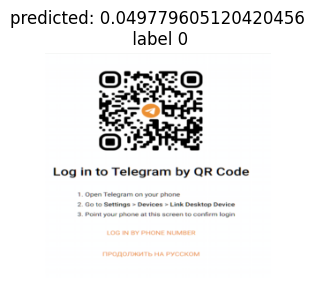

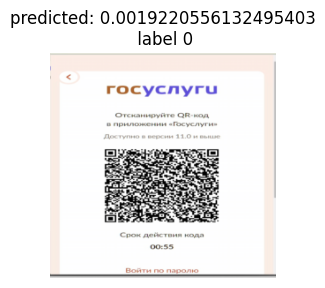

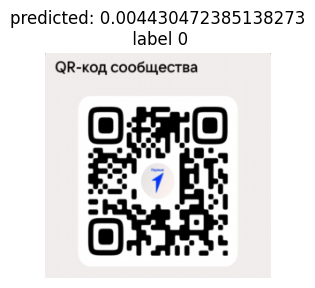

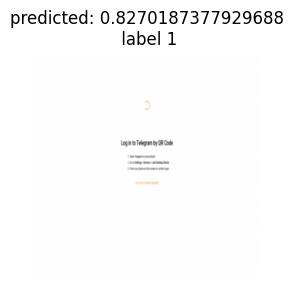

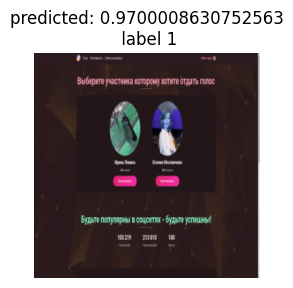

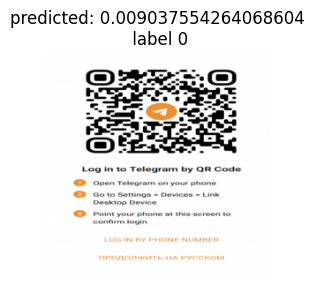

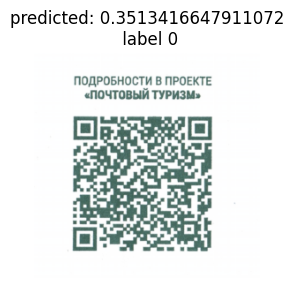

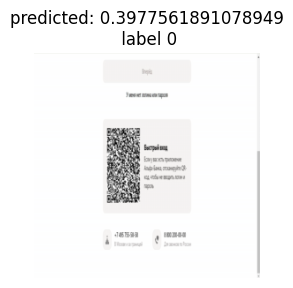

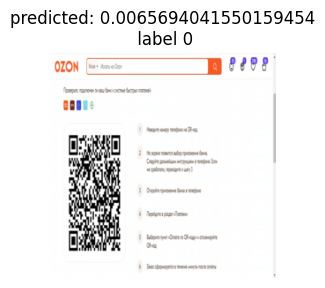

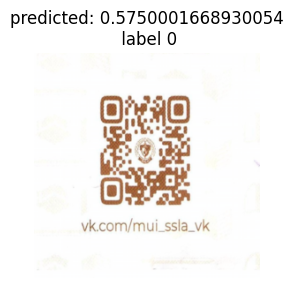

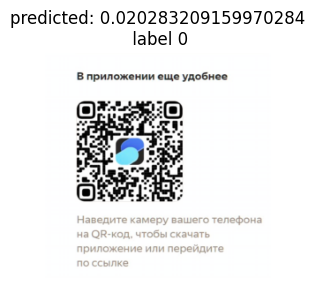

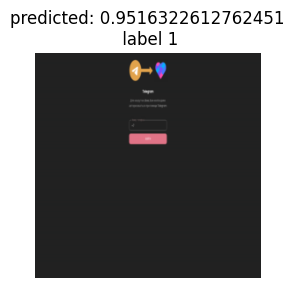

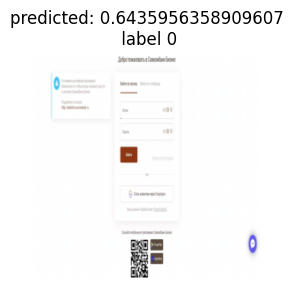

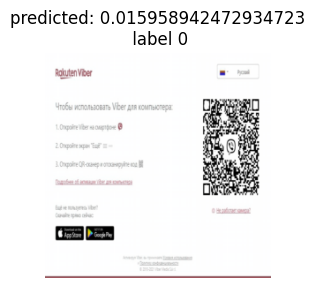

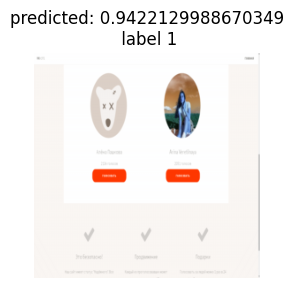

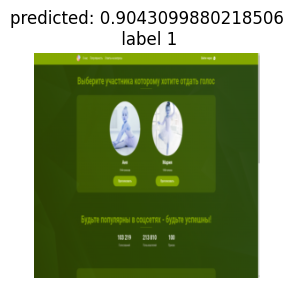

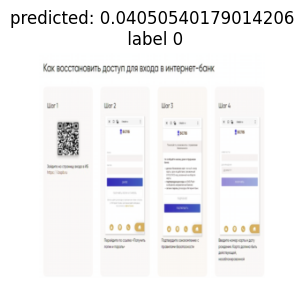

In [35]:
num_images = 2
was_training = model_ft.training
model_ft.eval()
images_so_far = 0
fig = plt.figure()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(DataLoader(dataset, batch_size=10, shuffle=True)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = sigm(model_ft(inputs))
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, 1)
            ax.axis('off')
            ax.set_title(f'predicted: {outputs[j][0].item()}\n label {labels[j].item()}')
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model_ft.train(mode=was_training)
                # return
    model_ft.train(mode=was_training)

In [ ]:
preds

In [ ]:
optimizer = optim.Adam(model_ft.parameters(), lr=0.1)

model_ft.train()
outputs = sigm(model_ft(inputs))
_, preds = torch.max(outputs, 1)
loss = criterion(outputs, labels)
# print('train output:', outputs)
loss.backward()
optimizer.step()

model_ft.eval()
outputs = sigm(model_ft(inputs))

print(labels)
print('valid outputs', outputs)

In [ ]:
labels

In [ ]:
sigm(outputs)

In [ ]:
sigm = nn.Sigmoid()
model = models.resnet152(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model = model.to(device)
out = sigm(model(inputs))
print(out.shape)


In [ ]:
criterion = nn.BCELoss()
criterion(out, torch.unsqueeze(labels, 1).type('torch.FloatTensor').to(device))

In [ ]:
m = nn.Sigmoid()

In [ ]:
labels

In [ ]:
preds

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = torchvision.models.resnet152(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=30)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='/content/data/train/normal/1.jpg'
)

plt.ioff()
plt.show()
